In [1]:
import gmsh
import numpy as np
import meshio
import matplotlib.pyplot as plt
import importlib
import functions as func
import Model
import Load
import Convergence

import contextlib
import os
from urllib.request import urlretrieve
from scipy.integrate import solve_ivp
from scipy.sparse import linalg
from sympy import *
from scipy.sparse import csr_matrix


#### Breakwater parameters

In [2]:
# Domain parameters
seaside = 10  # Length of the domain in x-direction
roof = 13  # Length of the domain in y-direction (roof of the crownwall)
top = 10 # top of the caisson
wall = 8 # location of the left side of the crownwall
tip = 1 # tip of the crownwall

#### Mesh definition

In [3]:
importlib.reload(Model) # reload Model.py for changes in file

# Mesh size
lc_big = 0.8
lc_small = 0.4

interior_tag, sea_side_tag, bottom_side_tag = Model.Mesh(lc_small, lc_big, seaside, roof, top, wall, tip)

#### Mesh plotting & boundary visualization

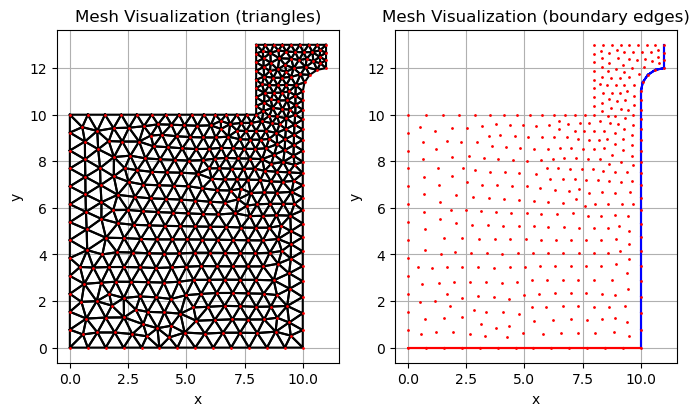

In [4]:
importlib.reload(Model) # reload Model.py for changes in file

# Read mesh from file
points, triangles, group_bottom, group_sea, bottom_edges, sea_edges, mesh = Model.form_mesh(bottom_side_tag, sea_side_tag)

# Plot triangles
fig, ax = plt.subplots(1,2, figsize=(8, 8))
for tri in triangles:
    coords = points[tri]
    coords = np.vstack((coords, coords[0]))  # close the triangle
    ax[0].plot(coords[:, 0], coords[:, 1], 'k-')
ax[0].plot(points[:, 0], points[:, 1], 'ro', markersize=1)
ax[0].set_aspect('equal')
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].set_title("Mesh Visualization (triangles)")
ax[0].grid(True)

# Plot edges
for edge in sea_edges:
    coords = points[edge]
    coords = np.vstack((coords, coords[0]))  # close the line
    ax[1].plot(coords[:, 0], coords[:, 1], 'blue', label = "ver")
for edge in bottom_edges:
    coords = points[edge]
    coords = np.vstack((coords, coords[0]))  # close the line
    ax[1].plot(coords[:, 0], coords[:, 1], 'red', label = "hor")
ax[1].plot(points[:, 0], points[:, 1], 'ro', markersize=1)
ax[1].set_aspect('equal')
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].set_title("Mesh Visualization (boundary edges)")
ax[1].grid(True)
plt.show()

#### Generating Load

h1 10 h2 11 d 15
p1 30165.75019310867 p3 112.66522898705416
p1til 0 p2til 37.2825 p3til 82.85


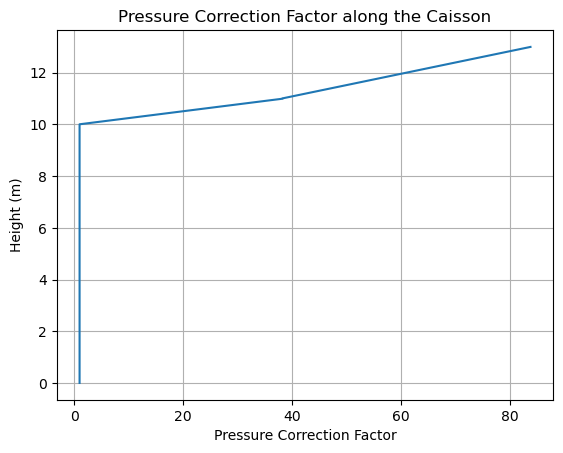

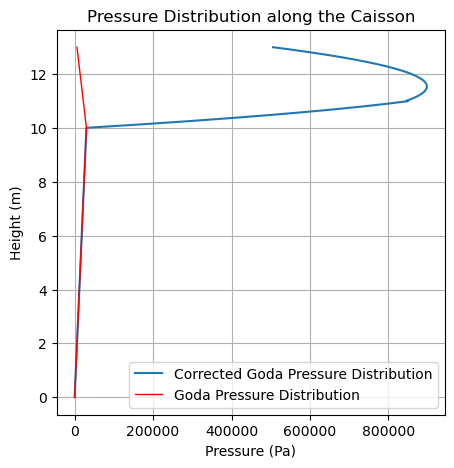

In [5]:
importlib.reload(Load) # reload Model.py for changes in file

# examples of input values
h = 10 # water depth [m]
beta = 2
k = 2 * np.pi / 10  # wave number, assuming a wavelength of 10 m

# Load parameters
H = 1
h_tot = 13 # m
eta = 5 #surface elevation [m] (time dependent)

d = 10 
h1 = h
h2 = 11 # height to start of curvature

goda = Load.goda_original(d, beta, H, eta, k)
q_goda = Load.array_Goda(h_tot, h1, h2, eta, goda, k, H, printing = True)

#### Parameters and boundary condtions

In [6]:
importlib.reload(Model) # reload Model.py for changes in file

# Problem parameters
E = 36e9  # Young's modulus in Pa
nu = 0.3  # Poisson's ratio
k_bottom = -5000000000
density = 2500  # Density in kg/m^3
body_force = np.array([0, -9.81 * density])  # Body force (gravity)
# body_force = np.array([0, 0])  # Body force (gravity)
C = func.elasticity_tensor(E, nu)
Force = 1
load = q_goda

K, M, f = Model.BC(mesh, triangles, points, C, density, body_force, bottom_edges, sea_edges, k_bottom, roof, load)



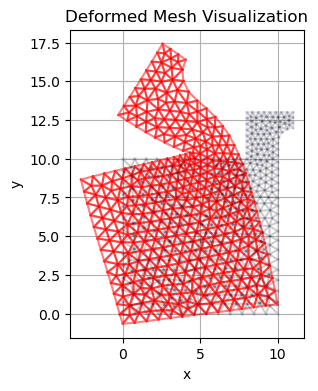

In [7]:
# Solve the system of equations
u = np.linalg.solve(K, f)

# Reshape the solution vector into a 2D array for visualization and magnify by 1e3
u_reshaped = u.reshape(-1, 2) * 1e3


# Plot the deformed mesh
plt.figure(figsize=(8, 4))
for tri in triangles:
    coords = points[tri]
    coords_displaced = coords + u_reshaped[tri]
    coords = np.vstack((coords, coords[0]))  # close the triangle
    coords_displaced = np.vstack((coords_displaced, coords_displaced[0]))  # close the triangle
    plt.plot(coords[:, 0], coords[:, 1], 'k-', alpha=0.1)
    plt.plot(coords_displaced[:,0],coords_displaced[:,1], 'r-', alpha=0.5)
plt.plot(points[:, 0], points[:, 1], 'bo', markersize=1, alpha =0.1)
plt.gca().set_aspect('equal')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Deformed Mesh Visualization")
plt.grid(True)
plt.show()

#### Central difference method

In [8]:
K = csr_matrix(K)
M = csr_matrix(M)

dt = 0.3 # timestep
T = 20 # total time
time_steps = np.arange(0, T, dt)
beta = 1/4
gamma = 1/2

In [9]:
importlib.reload(Model) # reload Model.py for changes in file

amplification = 10000

u_hist = Model.time_discretization(amplification, f, K, M, time_steps, dt, gamma, beta)

In [10]:
importlib.reload(Model) # reload Model.py for changes in file

# Model.plot_all(time_steps, u_hist, points)

<module 'Model' from 'c:\\Users\\TUDelftSID\\OneDrive\\Civiel\\CIEM4220 Computational Modelling\\CIEM4220_CM\\model\\Model.py'>

#### Beginning Convergence part

In [11]:
# nodes that are followed to find out when the model converges decreasing lc and dt
top_left = np.where((points[:,1] == top) & (points[:,0] == 0))
top_right = np.where((points[:,1] == roof) & (points[:,0] == seaside+tip))


#### Convergence for mesh size (takes a long time to run)

In [12]:
# Form values for a decreasing mesh size
start = 3.0          # Initial value of lc
factor = 0.8         # 60% of previous
num_values = 16      # Number of elements

lc = start * factor ** np.arange(num_values)
print(lc)

[3.         2.4        1.92       1.536      1.2288     0.98304
 0.786432   0.6291456  0.50331648 0.40265318 0.32212255 0.25769804
 0.20615843 0.16492674 0.1319414  0.10555312]


In [13]:
importlib.reload(Convergence) # reload Convergence.py for changes in file

displacement_lc = Convergence.mesh_size(lc, time_steps, seaside, roof, top, wall, tip, C, density, body_force, k_bottom, load, amplification, dt, gamma, beta, top_left);



lc = 3.0 is done
lc = 2.4 is done

c:\Users\TUDelftSID\OneDrive\Civiel\CIEM4220 Computational Modelling\CIEM4220_CM\model\Model.py:174: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  a_n = linalg.spsolve(M, f - K @ u_n)



lc = 1.92 is done
lc = 1.54 is done
lc = 1.23 is done
lc = 0.98 is done
lc = 0.79 is done
lc = 0.63 is done
lc = 0.5 is done
lc = 0.4 is done
lc = 0.32 is done
lc = 0.26 is done
lc = 0.21 is done
lc = 0.16 is done
lc = 0.13 is done
lc = 0.11 is done

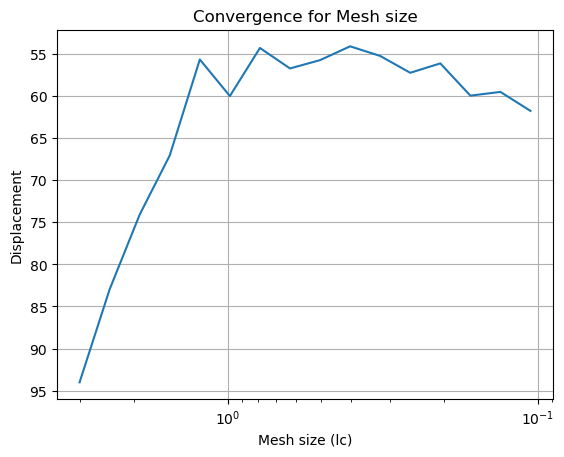

In [14]:
# Plotting the values
plt.figure()
plt.semilogx(lc, displacement_lc)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel('Mesh size (lc)')
plt.ylabel('Displacement')
plt.title('Convergence for Mesh size')
plt.grid()
plt.savefig('Convergence for mesh size', dpi=300)

#### Convergence for timestep (takes a long time to run)

In [15]:
T = 60 # total time (preferably an integer)
dt_list = [T/10, T/20, T/30, T/60, T/100, T/120, T/180, T/240] # decreasing dt 
print(dt_list)

[6.0, 3.0, 2.0, 1.0, 0.6, 0.5, 0.3333333333333333, 0.25]


In [16]:
importlib.reload(Convergence) # reload Convergence.py for changes in file
displacement_dt = Convergence.time_step(T, T, dt_list, amplification, f, K, M, gamma, beta, top_left)

dt = 6.0 is done
dt = 3.0 is done
dt = 2.0 is done
dt = 1.0 is done
dt = 0.6 is done
dt = 0.5 is done
dt = 0.3333333333333333 is done
dt = 0.25 is done


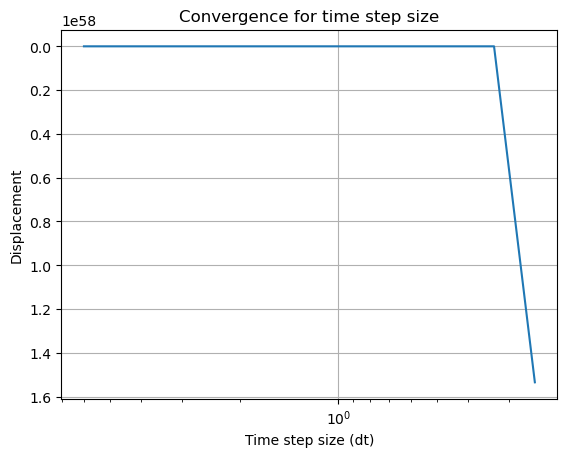

In [17]:
# Plotting the values
plt.figure()
plt.semilogx(dt_list, displacement_dt)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel('Time step size (dt)')
plt.ylabel('Displacement')
plt.title('Convergence for time step size')
plt.grid()
plt.savefig('Convergence for time step', dpi=300)